## Golden Master Image Algorithm (AS IS)

In [1]:
import numpy as np
import cv2
import operator
from matplotlib import pyplot as plt
import sys 

#Scripts para leer y procesar imagen
sys.path.insert(0, '../Golden Master (AS IS)')
import readImage
import preProcessing as pP
import sorts as srt
import perspective as pPe
import indAnalysis as inA

In [2]:
batch = False
qr = '601170500100412'

### Read Image

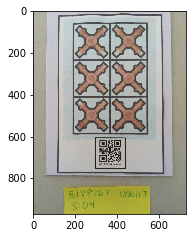

In [3]:
#Read from local file local = True, from db local = False, count = Test repeated
imgBGR = readImage.readImage(qr, local = False, count = 0)
if(isinstance(imgBGR, str)):
    print(imgBGR)
else: 
    # show the original image
    if (not batch):
     plt.subplot(121),plt.imshow(cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB))
     plt.show()

### Find Border of Biggest Square

Length:  4 type: <class 'list'>
(970, 728, 3)


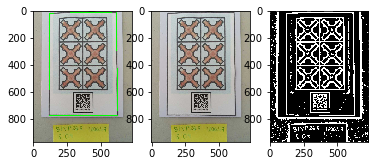

In [4]:
if(isinstance(imgBGR, str)):
    print(imgBGR)
else: 
    imgResized = pP.resizeImg(imgBGR, 728)
    
    imgBinary = pP.contourBinarization(imgBGR, 3, 7, 85, 2, inverse = True, mean = False)

    #Checkpoint
    #cv2.imwrite('BSbinpy.png', imgBinary)

externalSquare = pP.findTreeContours(imgBinary)
bgrCopy = imgBGR.copy()
cv2.drawContours(bgrCopy, [externalSquare[0]], -1, (0, 255, 0), 3)

#show contour image
# show resized and binary images
if (not batch):
    print("Length:  " + str(len(externalSquare)) + " type: " + str(type(externalSquare)))
    print(imgBGR.shape)
    plt.subplot(131),plt.imshow(cv2.cvtColor(bgrCopy,cv2.COLOR_BGR2RGB))
    plt.subplot(132),plt.imshow(cv2.cvtColor(imgResized,cv2.COLOR_BGR2RGB))
    plt.subplot(133),plt.imshow(imgBinary, 'gray')
    plt.show()

### Validate Perspective for Biggest Square

[array([[120,  23]], dtype=int32), array([[612,  15]], dtype=int32), array([[118, 774]], dtype=int32), array([[624, 774]], dtype=int32)]


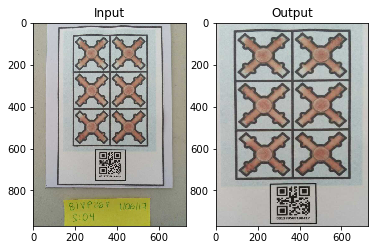

In [5]:
#Order points to identify region of interest
#printPoints(externalSquare)
externalOrdSquare = srt.sortPointsContours(externalSquare)
imgValidated = pPe.perspectiveTransform(imgBGR, externalOrdSquare[1], -5)

if(not batch):
    print(externalOrdSquare[0])
    plt.subplot(121),plt.imshow(cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)),plt.title('Input')
    plt.subplot(122),plt.imshow(cv2.cvtColor(imgValidated,cv2.COLOR_BGR2RGB)),
    plt.title('Output')
    plt.show()

### Validate Perspective for "Test Square" 

2


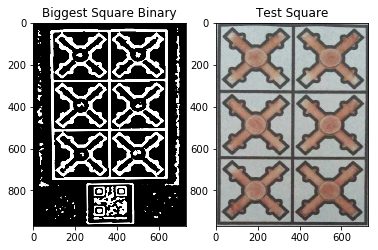

In [6]:
#Test Square lives inside Biggest Square and holds individual test's squares (a.k.a. X-Markers and XM Group)
#Do the actual perspective transform (previous one was for validating test device is there, and all margins align)
perspectiveBinary = pPe.perspectiveTransform(imgBinary, externalOrdSquare[1], -5, True)
perspectiveBGR = pPe.perspectiveTransform(imgBGR, externalOrdSquare[1], -5)
external = pP.findExternalContours(
    perspectiveBinary)
testSquareBinary = pPe.getTestSquare(perspectiveBinary, external, True)  
testSquareBGR = pPe.getTestSquare(perspectiveBGR, external)

if (not batch):
    print(len(external))
    plt.subplot(121),plt.imshow(perspectiveBinary, 'gray'),plt.title('Biggest Square Binary')
    plt.subplot(122),plt.imshow(cv2.cvtColor(testSquareBGR,cv2.COLOR_BGR2RGB)),plt.title('Test Square')
    plt.show()

### Histogram Equalization for "Test Square"

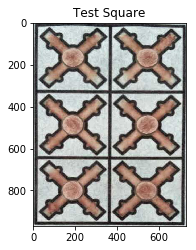

In [7]:
testSquareBGR = pP.equalizeHistogram(testSquareBGR)

if (not batch):
    plt.subplot(122),plt.imshow(cv2.cvtColor(testSquareBGR,cv2.COLOR_BGR2RGB)),plt.title('Test Square')
    plt.show()

### Validate Individual Tests (a.k.a. X-M Markers)

Approx ind area: 88260.0
Number of X-Markers found: 6


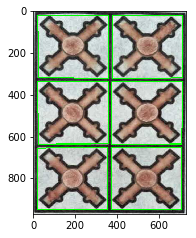

In [8]:
testSquareBGRCopy = testSquareBGR.copy()
height, width = testSquareBGR.shape[:2]
areaInd = (height*width/8) - 10
#Binarization is required again because lost of details on first binarization
contoursInd = pP.findTreeContours(pP.contourBinarization(testSquareBGR, 3, 7, 85, 2, mean = False),areaInd)
if(len(contoursInd) == 7 ): 
    contoursInd = contoursInd[1:]
for c in contoursInd:
    cv2.drawContours(testSquareBGRCopy, [c], -1, (0, 255, 0), 3)

if (not batch):  
    print("Approx ind area: " + str(areaInd))
    print("Number of X-Markers found: " + str(len(contoursInd)))
#Draw contour for ind tests (a.k.a. X-Markers)
    plt.subplot(121),plt.imshow(cv2.cvtColor(testSquareBGRCopy,cv2.COLOR_BGR2RGB))
    plt.show()

### Crop Individual Test's Images (a.k.a. X-M Markers)

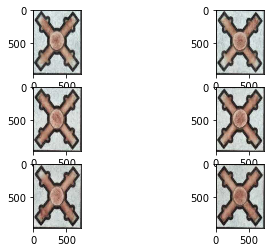

(970, 728, 3)


In [9]:
srt.sortTests(contoursInd)
listTests = []
if(len(contoursInd) == 6):
    for i,c in enumerate(contoursInd):
        test = pPe.getIndTest(testSquareBGR,c)
        listTests.append(test)         
    if (not batch):
        for i,test in enumerate(listTests):
            plt.subplot(321 + i),plt.imshow(cv2.cvtColor(test,cv2.COLOR_BGR2RGB))
        plt.show()
    print(test.shape)

### X-Marker Analysis (a.k.a. Sitios de prueba)

(90, 90)


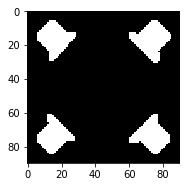

In [10]:
mask = inA.readMask("../../Imagenes/mask_inv.png")
print(mask.shape)

if (not batch):
    plt.subplot(121),plt.imshow(mask, 'gray')
    plt.show()

(90, 90)
47.78


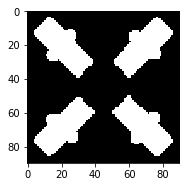

In [11]:
#Mask X nearly full white
mask2 = inA.readMask("../../Imagenes/mask3.png")
print(mask2.shape)
print(cv2.countNonZero(mask2) / 50)
if (not batch):
    plt.subplot(121),plt.imshow(mask2, 'gray')
    plt.show()

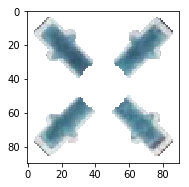

In [16]:
#Fixed size 90x90
listTests = inA.resizeAll(listTests)
listTestsBinary = []
listTestsBinaryMask = []
listTestsBinaryMaskEroDil = []

#Get control statistics
control = ~(inA.andOperation(listTests[5],mask2))

stats = inA.controlStats(listTests[5])

'''
print('H values, mean: ' + str(stats['H_']) + ', median: ' + str(stats[1]) + 
      ', std: ' + str(stats[2]))
print('S values, mean: ' + str(statsS[0]) + ', median: ' + str(statsS[1]) + 
      ', std: ' + str(statsS[2]) + ' P25: ' + str(statsS[3]))
'''
plt.subplot(121),plt.imshow(cv2.cvtColor(control,cv2.COLOR_BGR2RGB))
plt.show()

In [35]:
img = listTests[0]
imgSize = 90
num_channels = 3
print(img.shape)
img = np.multiply(img, 1.0/255.0)
img = img.reshape(1, -1)
img.shape

(90, 90, 3)


(1, 24300)

In [ ]:
#resized RGB
if (not batch):
    for i, test in enumerate(listTests):
        plt.subplot(321 + i),plt.imshow(cv2.cvtColor(test,cv2.COLOR_BGR2RGB))
        #Checkpoint
        #cv2.imwrite(str(i) + 'indRespy.png', cv2.cvtColor(test,cv2.COLOR_RGB2BGR))
    plt.show()

#X-Markers color segmented
plt.subplots_adjust(hspace=0.7)
if (not batch):
    for i, test in enumerate(listTests):
        test = inA.colorSegmentation(test, stats, statsS)
        plt.subplot(321 + i),plt.imshow(cv2.cvtColor(test[0],cv2.COLOR_RGB2BGR)),
        plt.title("Area: " + str(test[2])),plt.margins(ymargin = 5)
        #Checkpoint
        #cv2.imwrite(str(i) + 'indRespy.png', cv2.cvtColor(test,cv2.COLOR_RGB2BGR))
    plt.show()
    
#X-Markers resized binary
for i, test in enumerate(listTests):
    #Checkpoint
    #cv2.imwrite(str(i) + 'indRespy.png', pP.BGR2gray(cv2.cvtColor(test,cv2.COLOR_RGB2BGR)))
    testBin = pP.contourBinarization(test, 3, 3, 45, 4, Gs = 0, inverse = False, mean = True)
    #Checkpoint
    #cv2.imwrite(str(i) + 'indBinpy.png', testBin)
    listTestsBinary.append(testBin)
    if (not batch):
        plt.subplot(321 + i),plt.imshow(testBin, 'gray')
if (not batch):
    plt.show()
    print(listTestsBinary[0].shape)

#X-Markers binary with mask
for i, test in enumerate(listTestsBinary):
    testBinMask = inA.andOperation(test, mask)
    #Checkpoint
    #cv2.imwrite(str(i) + 'indBinMaskpy.png', testBinMask)
    listTestsBinaryMask.append(testBinMask)
    if (not batch):
        plt.subplot(321 + i),plt.imshow(testBinMask, 'gray')
if(not batch):
    plt.show()

# erode and dilate blobs
for i, test in enumerate(listTestsBinaryMask):
    test = inA.erosionDilation(test, 3)
    #Checkpoint
    #cv2.imwrite(str(i) + 'indEroDilpy.png', test)
    test = cv2.bitwise_not(test)
    #Checkpoint
    #cv2.imwrite(str(i) + 'indNot.png', test)
    listTestsBinaryMaskEroDil.append(test)
    if (not batch):
        plt.subplot(321 + i),plt.imshow(test, 'gray')
if (not batch):
    plt.show()

In [ ]:
#Blob detection
listBlobs = []
for i,img in enumerate(listTestsBinaryMaskEroDil):
    imgCopy = img.copy()
    blobs = inA.blobDetect(img)
    listBlobs.append(blobs)
    if(not batch):
        if(operator.mod(i,2) != 0): #Print two by line
            print("Blobs detected: " + str(len(listBlobs[i-1])) + 
              " Blobs detected: " + str(len(listBlobs[i])))
        plt.subplot(321 + i),plt.imshow(inA.drawBlobs(imgCopy, blobs), 'gray')
plt.show()

#Test results using blobs
for i, img in enumerate(listTestsBinary):
    if(operator.mod(i,2) != 0): #Print two by line
        if(not batch):
            print("Result: " + inA.blobAnalysis(img, listBlobs[i-1]) + 
              " Area: " + str(inA.areaEstimation(listBlobs[i-1])) +
              " Result: " + inA.blobAnalysis(img, listBlobs[i]) +
             " Area: " + str(inA.areaEstimation(listBlobs[i])))